# 02. Data Preparation

In [1]:
import pandas as pd
import numpy as np
import src.utils as utils
from ast import literal_eval
from datetime import date, datetime

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load the datasets
spotify_artist_csv = pd.read_csv('data/raw/artists.csv')
spotify_tracks_csv = pd.read_csv('data/raw/tracks.csv')
kpop_gg_csv = pd.read_csv('data/raw/kpop_gg.csv')
kpop_bg_csv = pd.read_csv('data/raw/kpop_bg.csv')
kpop_idols_csv = pd.read_csv('data/raw/kpop_all_idols.csv')

### a. Preparation for Spotify Data

In [3]:
# Rename spotify data columns, convert to proper data types, and normalize string data types
spotify_artist = spotify_artist_csv.rename(columns = {'id': 'id_artists', 'name': 'artists', 'popularity': 'artist_popularity'})

# Filter only kpop genre artists
k_genres = ["'k-pop'", "'k-pop girl group'", "'korean ost'", "'korean city pop'", "'korean pop'", "'classic k-pop'", "'k-pop boy group'", "'korean r&b'", "'k-rock'", "'k-rap'"]  
k_genres_list = '|'.join(k_genres)
spotify_kpop_artist = spotify_artist.loc[spotify_artist['genres'].str.contains(k_genres_list, case=False)].reset_index(drop = True)
spotify_kpop_artist['artists'] = spotify_kpop_artist['artists'].str.lower()

# Rename column names of spotify_tracks
spotify_tracks = spotify_tracks_csv.rename(columns = {'id': 'id_tracks', 'name': 'tracks_name', 'popularity': 'tracks_popularity', 'mode': 'modality'})

# convert datetime column
spotify_tracks['release_date'] = pd.to_datetime(spotify_tracks['release_date'])

# explode artists column because there are songs performed by more than one artists, just get the most popular artist
spotify_tracks['id_artists'] = spotify_tracks['id_artists'].apply(literal_eval)
exploded_tracks = spotify_tracks.explode('id_artists').drop_duplicates()
spotify_kpop_tracks = pd.merge(exploded_tracks.drop('artists', axis = 1), spotify_kpop_artist, how = 'inner', on = ['id_artists'])


### b. Preparation for Kpop Data

In [4]:
# Rename kpop_idols data columns, grouping to see average and std of age for each group
kpop_idols = kpop_idols_csv.rename(columns = {'Stage Name': 'artists', 'Group': 'group', 'Other Group': 'other_group', 'Date of Birth': 'birth_date', 'Gender': 'gender'})
kpop_idols['group'] = kpop_idols['group'].str.lower()
kpop_idols['artists'] = kpop_idols['artists'].str.lower()
kpop_idols.loc[kpop_idols['group'] == "tvxq", 'group'] = "tvxq!"
kpop_idols.loc[kpop_idols['group'] == "cosmic girls", 'group'] = "wjsn"
kpop_idols['other_group'] = kpop_idols['other_group'].str.lower()
kpop_idols = (
 kpop_idols.assign(other_group=kpop_idols['other_group'].str.split(','))
   .explode('other_group')
   .reset_index(drop=True)
)
kpop_idols = kpop_idols[['artists', 'group', 'other_group', 'birth_date', 'gender']]
kpop_idols['birth_date'] = pd.to_datetime(kpop_idols['birth_date'])

In [5]:
# Rename columns
kpop_groups_csv = pd.concat([kpop_gg_csv, kpop_bg_csv])
kpop_groups = kpop_groups_csv.rename(columns = {'Name': 'group', 'Debut': 'debut', 'Company': 'company', 'Members': 'members', 'Orig. Memb.': 'orig_members', 'Active': 'active'})

# If the group happened to lose one or more member
kpop_groups['members_lost'] = np.where(kpop_groups['members'] - kpop_groups['orig_members'] < 0, True, False)

# if the group is on hiatus change to active
kpop_groups['active'] = kpop_groups.loc[kpop_groups['active'] == 'hiatus', 'active'] = 'active'
kpop_groups['group'] = kpop_groups['group'].str.lower()
kpop_groups['debut'] = pd.to_datetime(kpop_groups['debut'])
kpop_groups = kpop_groups[['group', 'debut', 'company', 'members_lost', 'active']]

# check if group comes from big company
big5_companies = ['JYP', 'SM', 'YG', 'HYBE', 'Big Hit', 'Be:lift', 'Cube']
big5_list = '|'.join(big5_companies)
kpop_groups['big5_company'] = kpop_groups.company.str.contains(big5_list)

# Kpop soloist (non group)
kpop_soloist = kpop_idols[kpop_idols.group.isna()].reset_index(drop = True)
kpop_soloist['group'] = 'soloist'

In [6]:
kpop_groups['artists'] = kpop_groups['group']
kpop_artists = pd.concat([kpop_groups, kpop_soloist[['artists', 'group']]]).reset_index(drop = True)
kpop_artists

,group,debut,company,members_lost,active,big5_company,artists
0,kara,2007-03-29,DSP,True,active,False,kara
1,2ne1,2009-05-06,YG,False,active,True,2ne1
2,t-ara,2009-07-29,MBK,True,active,False,t-ara
3,sistar,2010-03-06,Starship,False,active,False,sistar
4,4minute,2009-06-15,Cube,False,active,True,4minute
...,...,...,...,...,...,...,...
525,soloist,NaT,NaN,NaN,NaN,NaN,dongjun
526,soloist,NaT,NaN,NaN,NaN,NaN,huiyeon
527,soloist,NaT,NaN,NaN,NaN,NaN,jian
528,soloist,NaT,NaN,NaN,NaN,NaN,sitala


In [7]:
today = spotify_tracks['release_date'].max()

# Function to get days difference from track's release date
def datediff(debut, release):
    diff_days = (release-debut).days
    return diff_days

# Function to get average age of the group
def mean_group_age(kpop_idols, artists, group):

    if (group in kpop_idols.group.tolist()):
        kpop_idols = kpop_idols[kpop_idols.group == group].reset_index(drop= True)
        age_group = []
        for i in range(len(kpop_idols)):
            birthdate = kpop_idols.loc[i, 'birth_date']
            age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
            age_group.append(age)
       
    elif (group in kpop_idols.other_group.tolist()):
        kpop_idols = kpop_idols[kpop_idols.other_group == group].reset_index(drop= True)
        age_group = []
        for i in range(len(kpop_idols)):
            birthdate = kpop_idols.loc[i, 'birth_date']
            age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
            age_group.append(age)

    elif (group == 'soloist' and artists in kpop_idols.artists.tolist()):
        kpop_idols = kpop_idols[kpop_idols.artists == artists].reset_index(drop= True)
        age_group = []
        for i in range(len(kpop_idols)):
            birthdate = kpop_idols.loc[i, 'birth_date']
            age = today.year - birthdate.year - ((today.month, today.day) < (birthdate.month, birthdate.day))
            age_group.append(age)

    else:
        age_group = np.nan
    
    return np.mean(age_group)


### c. Merge Spotify and Kpop Data (Inner Join)

In [8]:
# Get kpop groups that listed in Spotify music platform
kpop_tracks_df = pd.merge(spotify_kpop_tracks, kpop_artists, how = 'left', on = 'artists')
kpop_tracks_df

,id_tracks,tracks_name,tracks_popularity,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,followers,genres,artists,artist_popularity,group,debut,company,members_lost,active,big5_company
0,0K25zmumCzn2kFmh9zcLWy,CANDY,47,217227,0,5JrfgZAgqAMywJpLpJM0eS,1996-09-07,0.741,0.977,10,...,23956.0,['classic k-pop'],h.o.t.,41,NaN,NaT,NaN,NaN,NaN,NaN
1,0HiKR0bVxA7VJCShQ6HrUC,Descent of Warriors,39,264600,0,5JrfgZAgqAMywJpLpJM0eS,1996-09-07,0.826,0.926,1,...,23956.0,['classic k-pop'],h.o.t.,41,NaN,NaT,NaN,NaN,NaN,NaN
2,2ppv5E2a22qoXwYdL6GjvS,Full of happiness,39,211373,0,5JrfgZAgqAMywJpLpJM0eS,1997-07-05,0.768,0.937,11,...,23956.0,['classic k-pop'],h.o.t.,41,NaN,NaT,NaN,NaN,NaN,NaN
3,2khPCdofF2cFTDKjINZavV,We are the future,37,220733,0,5JrfgZAgqAMywJpLpJM0eS,1997-07-05,0.708,0.983,1,...,23956.0,['classic k-pop'],h.o.t.,41,NaN,NaT,NaN,NaN,NaN,NaN
4,0LW6E8rEAltX9Svci5M3Z1,Hope,45,260627,0,5JrfgZAgqAMywJpLpJM0eS,1998-09-01,0.652,0.968,0,...,23956.0,['classic k-pop'],h.o.t.,41,NaN,NaT,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,51GoV9wH57anm60ll5u5bS,GOKU VIBES,51,248100,1,1IoxcWz8vPDGOJBQNCGEvF,2020-08-26,0.583,0.739,0,...,4803.0,"['k-rap', 'korean trap']",futuristic swaver,43,NaN,NaT,NaN,NaN,NaN,NaN
2039,6nqXh3vnt1mMRYVIK6SL0L,You&I,50,215853,0,7ksQJtsXSRSrI5306UwIgH,2016-11-16,0.637,0.568,7,...,22107.0,"['korean ost', 'korean pop']",kim jong wan,54,NaN,NaT,NaN,NaN,NaN,NaN
2040,7qJX2FVVmnDHV0WJCWndRJ,안녕이라고 말하지마,26,231549,0,5Ecf8RR2UWFAvyeItabffF,1989-11-01,0.513,0.432,7,...,25444.0,['korean pop'],lee seung chul,43,NaN,NaT,NaN,NaN,NaN,NaN
2041,49BJ8VnN9u73NdDycrVgs0,Insomnia (불면증),39,206023,0,7luxe2wCwtDtkKSP8ZhPLn,2009-02-18,0.740,0.757,6,...,34886.0,"['classic k-pop', 'korean pop']",realslow,37,NaN,NaT,NaN,NaN,NaN,NaN


In [9]:
# Get new columns : days_after_debut (days difference from debut date and released date) 
# and mean_age_released (average age of all members when the track released)
kpop_tracks_df['days_after_debut'] = kpop_tracks_df.apply(lambda row: datediff(row['debut'], row['release_date']), axis=1)
kpop_tracks_df['days_after_debut'] = np.where(kpop_tracks_df['days_after_debut'] < 0, 0,kpop_tracks_df['days_after_debut'] )
kpop_tracks_df['mean_age'] = kpop_tracks_df.apply(lambda row: mean_group_age(kpop_idols, row['artists'], row['group']), axis=1)


In [10]:
spotify_kpop_df = kpop_tracks_df[['id_tracks', 'tracks_name', 'id_artists', 'artists', 'group', 'genres',
        'tracks_popularity', 'artist_popularity', 'duration_ms', 'explicit',  'release_date', 'danceability', 'energy',
        'time_signature', 'loudness', 'modality', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key',
        'followers', 'debut', 'release_date', 'active', 'big5_company', 'days_after_debut', 'mean_age']]

In [15]:
# saved as pickle
utils.pickle_dump(spotify_kpop_df, 'data/processed/spotify_kpop.pkl')

### d. Data Validation

Several columns that gonna used in this analysis:
- `tracks_popularity`: popularity of track in range 0-100 
- `artist_popularity`: popularity of artist in range 0-100 
- `duration_ms`: duration of the song (milisecond)
- `explicit`: whether it contains explicit content or not
- `danceability`: how danceable a song is in range 0-1
- `energy`: how energized a song is in range 0-1
- `time_signature`: major note of track [0:C, 1:C#, 2:D, ...] using Pitch Class notation
- `loudness`: how loud a song is in db
- `mode`: the modality of track (0: minor, 1: major)
- `speechiness`: the presence of spoken words in track range 0-1
- `acousticness`: how acoustic a track is in range 0-1
- `instrumentalness`: the absence of vocal sounds in track in range 0-1
- `liveness`: the presence of audience in track in range 0-1
- `the valence`: positiveness of the track in range 0-1 (high valence means the track sounds more positive, happy, cheerful or euphoric)
- `tempo`: overal tempo of track in BPM
- `time_signature`: a sign used in music to indicate meter of composition (mostly 4)
- `followers`: amount followers the group has in spotify
- `big4_company`: condition if the group comes from current big entertainment company (SM, JYP, YG, or HYBE/Big Hit)
- `active`: condition if the group still active or not
- `days_after_debut`: how many days the track released after the group's debut
- `mean_age_released`: average of the member's age when the track was released

In [18]:
used_columns = ['tracks_popularity', 'artist_popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
        'time_signature', 'loudness', 'modality', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key',
        'followers', 'big5_company', 'days_after_debut', 'mean_age'] 

for col in used_columns:
    print(col)
    print(spotify_kpop_df[col].unique()[:5])
    print(spotify_kpop_df[col].nunique())
    print()

tracks_popularity
[47 39 37 45  0]
87

artist_popularity
[41 22 48 53 66]
59

duration_ms
[217227 264600 211373 220733 260627]
1718

explicit
[0 1]
2

danceability
[0.741 0.826 0.768 0.708 0.652]
520

energy
[0.977 0.926 0.937 0.983 0.968]
635

time_signature
[4 3 5 1]
4

loudness
[-2.318 -3.822 -5.637 -6.374 -3.883]
1594

modality
[1 0]
2

speechiness
[0.044  0.109  0.0523 0.0529 0.0857]
764

acousticness
[0.134   0.103   0.0111  0.00105 0.058  ]
1125

instrumentalness
[0.00e+00 2.11e-03 1.18e-06 7.27e-06 1.17e-01]
436

liveness
[0.145  0.0573 0.177  0.0838 0.144 ]
723

valence
[0.951 0.714 0.77  0.708 0.731]
738

tempo
[119.988  97.026 133.046 130.014  99.962]
1714

key
[10  1 11  0  7]
12

followers
[2.395600e+04 6.620000e+02 2.317240e+05 1.203750e+05 1.860723e+06]
365

big5_company
[nan True False]
2

days_after_debut
[  nan 1438.  556. 1165.   95.]
405

mean_age
[        nan 40.83333333 29.         35.         27.        ]
64



In [19]:
# Filter to columns that wanted to be analyzed
df = spotify_kpop_df[used_columns]

# Convert data to proper form and types
explicit_ls = {1: 'explicit', 0: 'non_explicit'}
df.explicit= df.explicit.map(explicit_ls)

pitch_class_ls = {0: 'C', 1: 'C#', 2: 'D', 3: 'D#', 4: 'E', 5: 'F', 6: 'F#', 7: 'G', 8: 'G#', 9: 'A', 10: 'A#', 11: 'B'}
df.key = df.key.map(pitch_class_ls)

mode_ls = {0: 'minor', 1: 'major'}
df.modality = df.modality.map(mode_ls)

df[['time_signature', 'modality', 'key', 'big5_company']] =  df[['time_signature', 'modality', 'key', 'big5_company']].astype(str)
df.dtypes

tracks_popularity      int64
artist_popularity      int64
duration_ms            int64
explicit              object
danceability         float64
energy               float64
time_signature        object
loudness             float64
modality              object
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
key                   object
followers            float64
big5_company          object
days_after_debut     float64
mean_age             float64
dtype: object

In [20]:
# Get numerical and categorical variable names
numerical_columns = list(df.dtypes[df.dtypes != "object"].index)
categorical_columns = list(df.dtypes[df.dtypes == "object"].index)
base = numerical_columns + categorical_columns
numerical_columns.remove('tracks_popularity')
base.remove('tracks_popularity')
len(base)

19

In [26]:
# Check if theres missing values
df.describe()

,tracks_popularity,artist_popularity,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,days_after_debut,mean_age
count,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2043.000000,2.043000e+03,974.000000,1087.000000
mean,51.524229,67.478218,221680.405286,0.650287,0.722768,-4.776759,0.087651,0.242005,0.005460,0.190693,0.547025,121.517775,6.687585e+06,1107.144764,26.871638
std,15.616949,17.258872,35114.864076,0.126233,0.190037,2.397455,0.080100,0.258061,0.061486,0.148728,0.217327,26.765462,1.072004e+07,805.245188,3.663607
min,0.000000,3.000000,42841.000000,0.202000,0.093200,-25.745000,0.023400,0.000178,0.000000,0.026500,0.066500,48.973000,5.110000e+02,0.000000,17.166667
25%,45.000000,55.000000,199911.000000,0.577000,0.605000,-5.775500,0.037850,0.037600,0.000000,0.092700,0.378000,99.988500,2.726150e+05,493.000000,24.750000
50%,53.000000,68.000000,217560.000000,0.667000,0.776000,-4.395000,0.058500,0.132000,0.000000,0.131000,0.554000,122.008000,1.817155e+06,993.000000,26.000000
75%,62.000000,80.000000,238193.000000,0.740000,0.872000,-3.196000,0.101000,0.394000,0.000001,0.263500,0.717000,136.076000,5.087427e+06,1574.000000,28.300000
max,91.000000,96.000000,622800.000000,0.954000,0.999000,0.049000,0.889000,0.994000,0.949000,0.990000,0.970000,207.819000,3.162381e+07,5609.000000,43.000000


In [39]:
def cat_age(age):
    if age <= 20:
        cat = '<20'
    elif 20 < age <= 25:
        cat = '20-25'
    elif 25 < age <= 30:
        cat = '25-30'
    elif 30 < age <= 35:
        cat = '35-30'
    else:
        cat = '>35'

def cat_days_after_debut(days):
    if days <= 365:
        cat = '<1year'
    elif 365 < days < 365 * 5:
        cat = '1-5years'
    elif 365 * 5 < days < 365 * 10:
        cat = '5-10years'
    else:
        cat = '>10years'



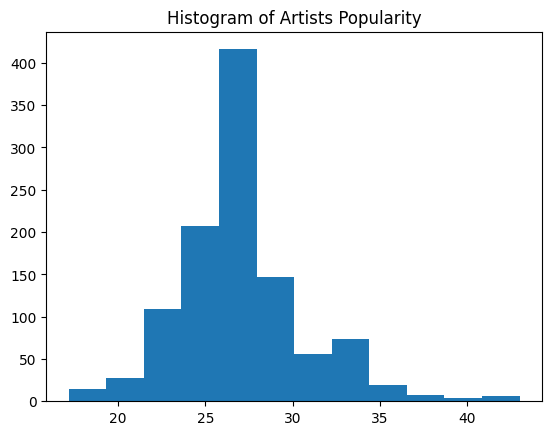

In [33]:
plt.hist(df.mean_age, bins = 12)
plt.title("Histogram of Artists Popularity")
plt.show()

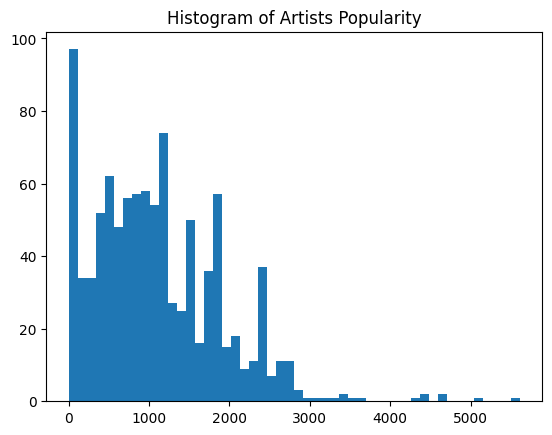

In [37]:
plt.hist(df.days_after_debut, bins = 50)
plt.title("Histogram of Artists Popularity")
plt.show()

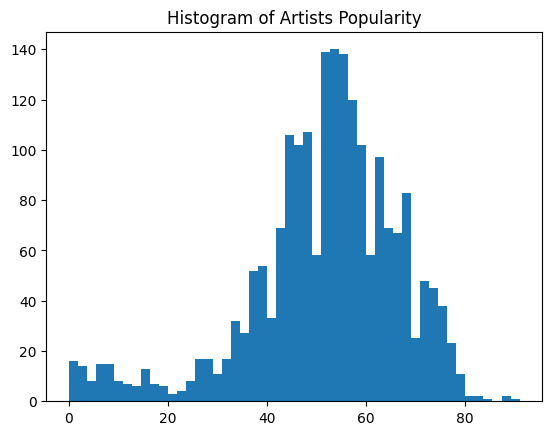

In [41]:
plt.hist(df.tracks_popularity, bins = 50)
plt.title("Histogram of Artists Popularity")
plt.show()

In [38]:
365 * 5

1825

In [31]:
df.isna().sum()

tracks_popularity       0
artist_popularity       0
duration_ms             0
explicit                0
danceability            0
energy                  0
time_signature          0
loudness                0
modality                0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
key                     0
followers               0
big5_company            0
days_after_debut     1069
mean_age              956
dtype: int64

In [21]:
# The missing value is `mean_age_released` or average age at released date of each group, 
# there are 6 groups who can't be found in database. 
# This variable is pretty hard to be estimated with values like mean or median, also it's impossible to be 0, so it needs to be dropped.

df = df.dropna(axis = 0)
df.sort_values(by = 'mean_age_released')

,tracks_popularity,artist_popularity,duration_ms,explicit,danceability,energy,time_signature,loudness,modality,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,followers,big5_company,days_after_debut,mean_age_released
759,45,50,241867,non_explicit,0.518,0.708,4,-4.389,minor,0.0375,0.2520,0.000000,0.1760,0.220,119.847,C,368163.0,False,1,15.40
23,42,73,290293,non_explicit,0.737,0.575,4,-5.784,minor,0.0402,0.4040,0.000005,0.0699,0.478,133.957,C#,2259111.0,True,0,16.00
14,54,73,216453,non_explicit,0.724,0.792,4,-2.219,major,0.0840,0.1490,0.000002,0.1100,0.580,100.009,C#,2259111.0,True,0,16.00
766,42,55,228960,non_explicit,0.756,0.806,4,-3.867,minor,0.0428,0.2250,0.000000,0.1040,0.742,109.956,C,667220.0,True,19,16.00
13,53,73,314867,non_explicit,0.516,0.496,4,-5.784,major,0.0290,0.5170,0.000000,0.1470,0.314,75.621,C#,2259111.0,True,95,16.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
682,56,62,216735,non_explicit,0.478,0.292,4,-8.161,major,0.0312,0.8940,0.000000,0.1210,0.208,131.831,G#,555680.0,False,4346,31.50
39,58,69,201112,non_explicit,0.711,0.885,4,-3.299,minor,0.0477,0.0044,0.000000,0.2070,0.866,121.978,F,1980623.0,True,4383,31.60
40,50,69,255012,non_explicit,0.531,0.634,4,-5.676,major,0.0325,0.1190,0.000000,0.2530,0.312,73.955,G,1980623.0,True,4383,31.60
683,59,62,201267,non_explicit,0.382,0.348,4,-6.694,major,0.0345,0.7290,0.000000,0.1000,0.290,131.082,G#,555680.0,False,4654,32.50


### e. Split Data

In [22]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [23]:
# save data
utils.pickle_dump(df, 'data/processed/spotify_kpop_cleaned.pkl')
utils.pickle_dump(df_train, 'data/processed/train.pkl')
utils.pickle_dump(df_val, 'data/processed/validation.pkl')
utils.pickle_dump(df_test, 'data/processed/test.pkl')